In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,Embedding,LSTM,SimpleRNN,GlobalAveragePooling1D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall

2021-10-22 09:05:29.960514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
imdb,info=tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAOL2N5/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAOL2N5/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteAOL2N5/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2021-10-22 09:06:30.777172: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 09:06:30.780723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 09:06:30.831276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 09:06:30.831899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-22 09:06:30.831973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-22 09:06:30.859540: I tensorflow/stream_executor/platform/def

In [3]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final=np.array(training_labels)
testing_labels_final=np.array(testing_labels)

2021-10-22 09:06:32.629380: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-22 09:06:32.633590: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000134999 Hz


In [4]:
vocab_size=10000 # Banyak kata/token
embedding_dim=16 # Ukuran/dimensi vektor embedding
max_length=120 # Jumlah maksimum kata dalam satu observasi
trunc_type='post' # Jika jumlah kata melebihi max_length, maka kata-kata dari akhir kalimat akan dihapus sampai max_length tercapai
oov_tok="<OOV>" # Jika terdapat kata yang tidak muncul pada data latih, maka kata tersebut akan diganti menjadi OOV

In [5]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [7]:
prec = Precision(name='prec')
rec = Recall(name='rec')

# RNN

In [8]:
inputs=Input(shape=(max_length,))
layer=Embedding(vocab_size,embedding_dim,input_length=max_length,trainable=False)(inputs)
layer=Dropout(0.05)(layer)
layer=Bidirectional(SimpleRNN(32))(layer)
layer=Dense(6,activation='relu')(layer)
output=Dense(1,activation='sigmoid')(layer)

model = Model(inputs=[inputs], outputs=[output])
adam = Adam(lr=0.001, decay=1e-5)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc',prec,rec])

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
dropout (Dropout)            (None, 120, 16)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                3136      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 163,533
Trainable params: 3,533
Non-trainable params: 160,000
___________________________________________________

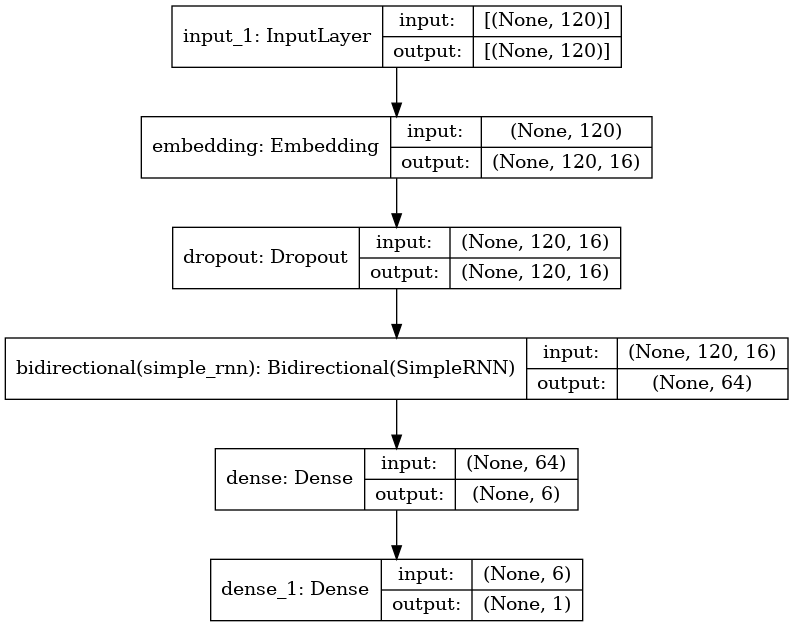

In [10]:
plot_model(model, to_file='RNN model.png', show_shapes=True)

In [11]:
EPOCHS=20
hist=model.fit(padded,training_labels_final,
               batch_size=50,
               epochs=EPOCHS,
               validation_data=(testing_padded,testing_labels_final))

Epoch 1/20


2021-10-22 09:06:59.388253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


  1/500 [..............................] - ETA: 20:36 - loss: 0.6958 - acc: 0.4600 - prec: 0.2667 - rec: 0.2000

2021-10-22 09:07:00.251904: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


500/500 [==============================] - 56s 107ms/step - loss: 0.6950 - acc: 0.5068 - prec: 0.5028 - rec: 0.4000 - val_loss: 0.6930 - val_acc: 0.5031 - val_prec: 0.5018 - val_rec: 0.8708
Epoch 2/20
500/500 [==============================] - 54s 108ms/step - loss: 0.6931 - acc: 0.5082 - prec: 0.5060 - rec: 0.8735 - val_loss: 0.6932 - val_acc: 0.5000 - val_prec: 0.5000 - val_rec: 1.0000
Epoch 3/20
500/500 [==============================] - 54s 107ms/step - loss: 0.6932 - acc: 0.4975 - prec: 0.4979 - rec: 0.9893 - val_loss: 0.6931 - val_acc: 0.5000 - val_prec: 0.5000 - val_rec: 1.0000
Epoch 4/20
500/500 [==============================] - 53s 106ms/step - loss: 0.6932 - acc: 0.4920 - prec: 0.4910 - rec: 0.5034 - val_loss: 0.6931 - val_acc: 0.5000 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 54s 107ms/step - loss: 0.6932 - acc: 0.4928 - prec: 0.4583 - rec: 0.3921 - val_loss: 0.6931 - val_acc: 0.5000 - val_prec: 0.5000 - val_rec: 1.000

In [12]:
def plot_ax(axes, metrics, title, epochs):
    val_met = 'val_' + metrics
    axes.plot(hist.history[metrics], c='blue', linewidth=1.5)
    axes.plot(hist.history[val_met], c='orange', linewidth=1.5)
    axes.set_title(title)
    axes.set_xticks(range(0, epochs, epochs // 10))
    axes.legend([metrics, val_met], loc='best')
    axes.set_ylabel(metrics)
    axes.grid()

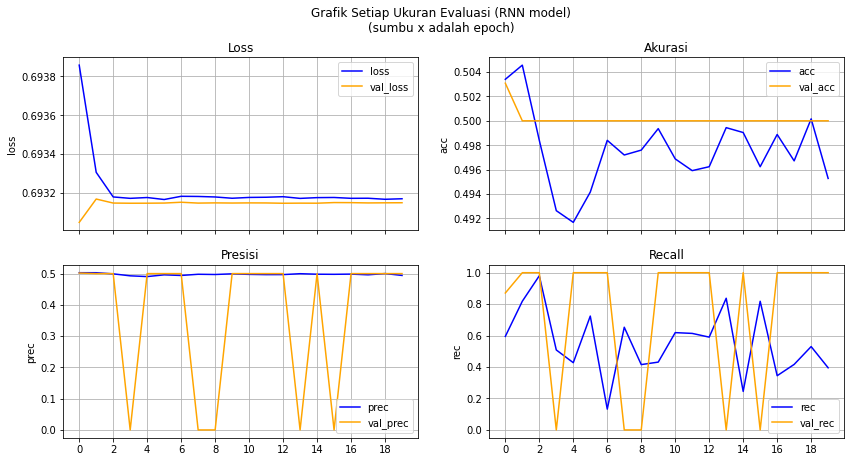

In [13]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', EPOCHS)
plot_ax(ax[0][1], 'acc', 'Akurasi', EPOCHS)
plot_ax(ax[1][0], 'prec', 'Presisi', EPOCHS)
plot_ax(ax[1][1], 'rec', 'Recall', EPOCHS)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Ukuran Evaluasi (RNN model)\n(sumbu x adalah epoch)')
plt.show()

In [14]:
testing_labels_pred=model.predict(testing_padded)

In [15]:
testing_labels_pred

array([[0.5012029],
       [0.5012029],
       [0.5012029],
       ...,
       [0.5012029],
       [0.5012029],
       [0.5012029]], dtype=float32)

In [16]:
Testing_labels_pred=np.zeros(testing_labels_pred.shape)
Testing_labels_pred[testing_labels_pred>0.5]=1
Testing_labels_pred=np.array(Testing_labels_pred)
Testing_labels_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [17]:
print(classification_report(testing_labels_final,Testing_labels_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12500
           1       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN

In [18]:
inputs=Input(shape=(max_length,))
layer=Embedding(vocab_size,embedding_dim,input_length=max_length,trainable=False)(inputs)
layer=Dropout(0.05)(layer)
layer=Conv1D(128,5,activation='relu')(layer)
layer=GlobalAveragePooling1D()(layer)
layer=Dense(6,activation='relu')(layer)
output=Dense(1,activation='sigmoid')(layer)

model2 = Model(inputs=[inputs], outputs=[output])
adam = Adam(lr=0.001, decay=1e-5)

model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc',prec,rec])

In [19]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7   

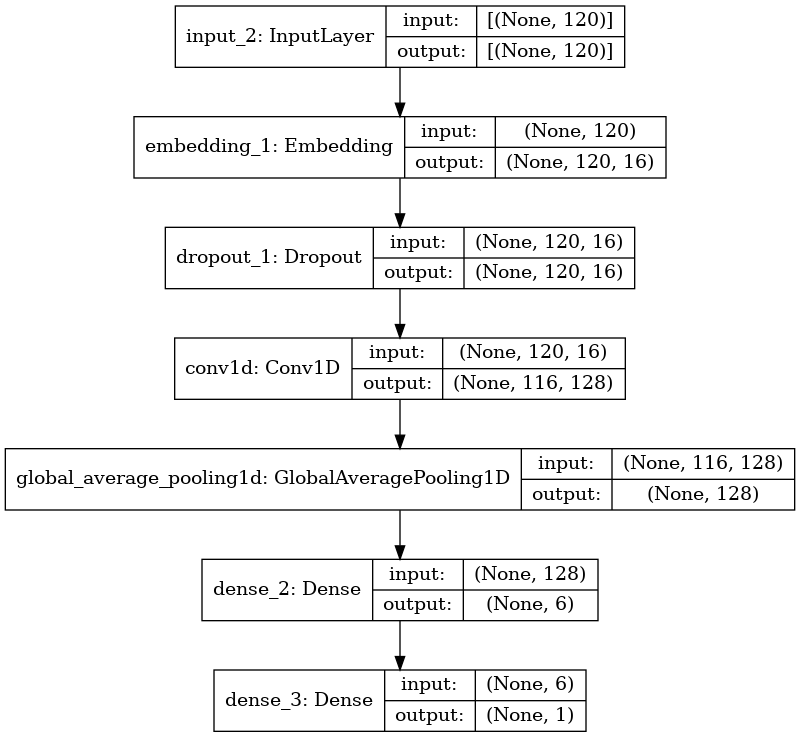

In [20]:
plot_model(model2, to_file='CNN model.png', show_shapes=True)

In [21]:
EPOCHS=20
hist=model2.fit(padded,training_labels_final,
               batch_size=50,
               epochs=EPOCHS,
               validation_data=(testing_padded,testing_labels_final))

Epoch 1/20


2021-10-22 09:26:23.698153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


500/500 [==============================] - 10s 7ms/step - loss: 0.6923 - acc: 0.5139 - prec: 0.5035 - rec: 0.8316 - val_loss: 0.6863 - val_acc: 0.5663 - val_prec: 0.5685 - val_rec: 0.5502
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.6856 - acc: 0.5539 - prec: 0.5570 - rec: 0.4802 - val_loss: 0.6810 - val_acc: 0.5705 - val_prec: 0.5572 - val_rec: 0.6867
Epoch 3/20
500/500 [==============================] - 4s 7ms/step - loss: 0.6814 - acc: 0.5593 - prec: 0.5601 - rec: 0.5917 - val_loss: 0.6781 - val_acc: 0.5770 - val_prec: 0.5687 - val_rec: 0.6377
Epoch 4/20
500/500 [==============================] - 3s 7ms/step - loss: 0.6797 - acc: 0.5661 - prec: 0.5649 - rec: 0.5738 - val_loss: 0.6769 - val_acc: 0.5786 - val_prec: 0.5673 - val_rec: 0.6626
Epoch 5/20
500/500 [==============================] - 3s 7ms/step - loss: 0.6770 - acc: 0.5791 - prec: 0.5774 - rec: 0.5818 - val_loss: 0.6760 - val_acc: 0.5791 - val_prec: 0.5669 - val_rec: 0.6699
Epoch 6/20
500/500 [

In [22]:
def plot_ax(axes, metrics, title, epochs):
    val_met = 'val_' + metrics
    axes.plot(hist.history[metrics], c='blue', linewidth=1.5)
    axes.plot(hist.history[val_met], c='orange', linewidth=1.5)
    axes.set_title(title)
    axes.set_xticks(range(0, epochs, epochs // 10))
    axes.legend([metrics, val_met], loc='best')
    axes.set_ylabel(metrics)
    axes.grid()

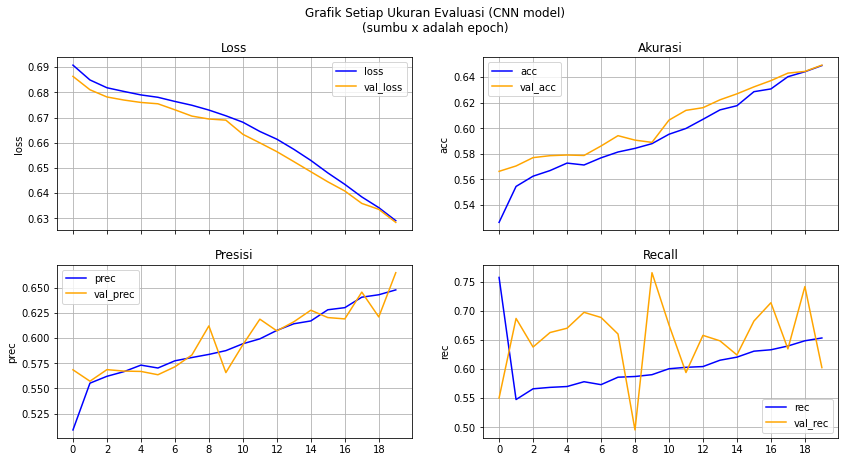

In [23]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', EPOCHS)
plot_ax(ax[0][1], 'acc', 'Akurasi', EPOCHS)
plot_ax(ax[1][0], 'prec', 'Presisi', EPOCHS)
plot_ax(ax[1][1], 'rec', 'Recall', EPOCHS)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Ukuran Evaluasi (CNN model)\n(sumbu x adalah epoch)')
plt.show()

In [24]:
testing_labels_pred2=model2.predict(testing_padded)

In [25]:
testing_labels_pred2

array([[0.39087003],
       [0.6200913 ],
       [0.38632438],
       ...,
       [0.26130122],
       [0.69842637],
       [0.6084056 ]], dtype=float32)

In [26]:
Testing_labels_pred2=np.zeros(testing_labels_pred2.shape)
Testing_labels_pred2[testing_labels_pred2>0.5]=1
Testing_labels_pred2=np.array(Testing_labels_pred2)
Testing_labels_pred2

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [27]:
print(classification_report(testing_labels_final,Testing_labels_pred2))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67     12500
           1       0.66      0.60      0.63     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000

